# 결정 트리
SVM처럼 결정 트리는 분류와 회귀 작업, 다중출력 작업이 모두 가능한 알고리즘

또한 매우 복잡한 데이터셋도 학습할 수 있는 강력한 알고리즘


캘리포니아 주택 가격 데이터셋을 훈련할 때도 과대적합이긴 하지만 TreeRegressor 모델을 훈련했었음

- 결정 트리는 최근에 자주 사용되는 가장 강력한 머신러닝 알고리즘 중 하나인 랜덤 포레스트의 기본 구성요소이기도 함

- **결정 트리의 훈련**, **시각화**, **예측 방법**에 대해 살펴본 후 사이킷런의 CART 훈련 알고리즘을 살펴보고 트리에 규제를 가하는 방법과 회귀 문제에 적용하는 방법 학습
- 마지막으로 결정 트리의 제약 사항에 관해 학습

In [20]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 결정 트리 학습과 시각화

- Iris 데이터셋에 DecisionTreeClassifier 훈련

In [21]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎의 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(X,y)

DecisionTreeClassifier(max_depth=2)

- export_graphviz() 함수를 사용해 그래프 정의를 iris_tree.dot 파일로 출력하여 훈련된 결정 트리 시각화 가능

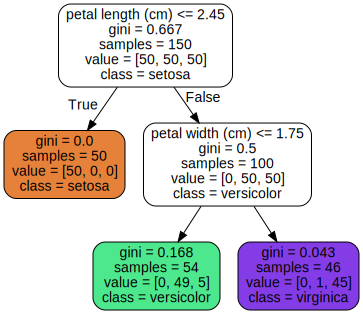

In [22]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

In [24]:
tree_clf2 = DecisionTreeClassifier(max_depth = 3)
tree_clf2.fit(X,y)

DecisionTreeClassifier(max_depth=3)

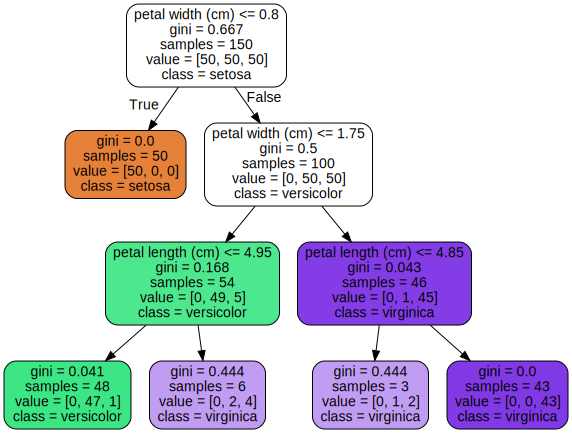

In [25]:
export_graphviz(
        tree_clf2,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

- 사이킷런에서 트리 모델 plot 그릴 수 있음

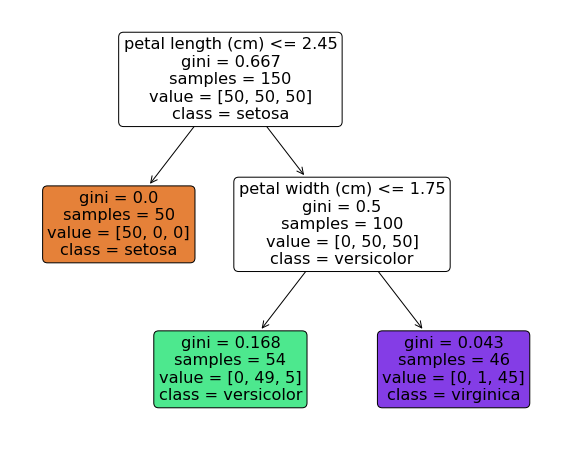

In [31]:
from sklearn.tree import plot_tree

plt.figure(figsize = (10,8)) # plot을 크게 보기 위함
plot_tree(tree_clf, filled = True, rounded = True,  # filled : class별로 색깔 칠하기
          feature_names = iris.feature_names[2:],
          class_names = iris.target_names)
plt.show()

### max_depth를 주지 않은 경우 
 - 리프 노드가 순수 노드가 될 때까지 성장. 즉, 과대적합

In [37]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎의 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth = 2,random_state = 42)
tree_clf.fit(X,y)

DecisionTreeClassifier(max_depth=2, random_state=42)

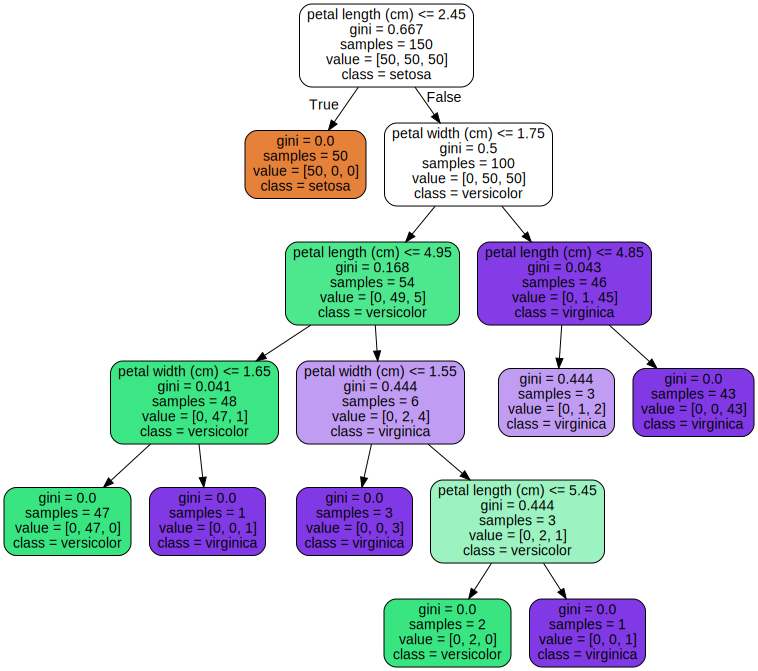

In [33]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

 - max_depth를 이용해서 일부만 그릴 수 있음

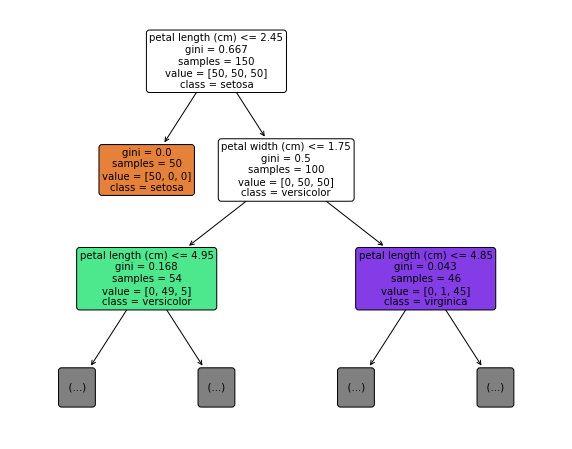

In [34]:
from sklearn.tree import plot_tree

plt.figure(figsize = (10,8)) # plot을 크게 보기 위함
plot_tree(tree_clf, filled = True, rounded = True, max_depth = 2, # filled : class별로 색깔 칠하기
          feature_names = iris.feature_names[2:],
          class_names = iris.target_names)
plt.show()

**지니 불순도**

$
G_i=1-\sum\limits_{k=1}^{n}{p_{i,k}}^{2}
$

-ex. [0,49,5]의 경우
- 1 - ((0/54)^2 + (49/54)^2 + (5/54)^2)
- 지니 불순도가 최소가 되도록 노드를 분할해서 트리를 생성하는 것이 결정 트리의 알고리즘

**엔트로피 불순도**

$
H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}p_{i,k}\text{log}_2(p_{i,k})
$

- 지니 불순도와 비숫하지만 ${p_{i,k}}^{2}$ 대신 $p_{i,k}log_2(p_{i,k})$ 사용

**분류에 대한 CART 비용 함수**

$
J(k,t_k) = \dfrac{m_{left}}{m}G_{left} + \dfrac{m_{right}}{m}G_{right}
$

여기에서

$
\begin{cases}
G_{left/rigth}\text{는 왼쪽/오른쪽 서브셋의 불순도} \\
m_{left/right}\text{는 왼쪽/오른쪽 서브셋의 샘플 수}
\end{cases}
$

### 결정 경계 확인

그림 저장: decision_tree_decision_boundaries_plot


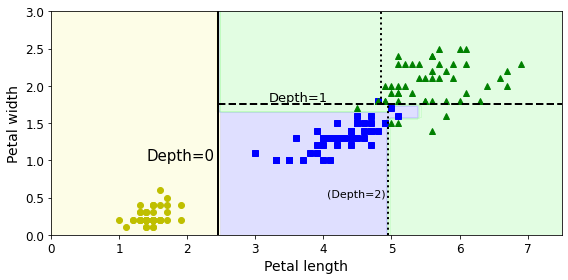

In [35]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

- 클래스와 클래스 확률을 예측

In [39]:
tree_clf.predict_proba([[5,1.5]]) # 각각의 클래스에 대한 확률, 이 중에서 가장 확률이 높은 클래스 선택

array([[0.        , 0.90740741, 0.09259259]])

###  훈련 세트에 민감

In [40]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # versicolor중에서 width가 가장 큰 샘플

array([[4.8, 1.8]])

- versicolor 에서 width가 가장 큰 샘플을 제외하고 모델을 학습시킨 결과

In [41]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(max_depth=2, random_state=40)

그림 저장: decision_tree_instability_plot


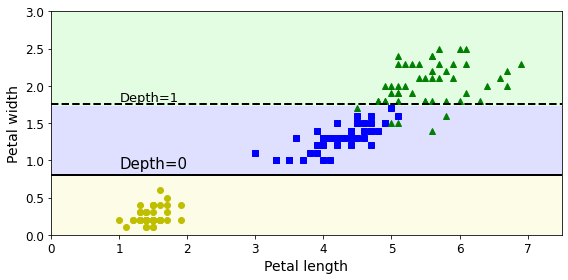

In [42]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()

- Petal length는 사용하지 않고 Petal width만 사용해서 모델을 학습시킨 것을 알 수 있음

### 제약이 없으면 모든 리프 노드가 순수 노드가 될 때까지 성장
- 훈련 세트에 정확하게 맞춘다는 뜻이므로 과대 적합이 된 모델을 만들게 됨
- 트리 성장에 대해 적절한 규제가 필요함(ex.max_depth)
 - 이러한 과정을 사전 가지치기라고 함

그림 저장: min_samples_leaf_plot


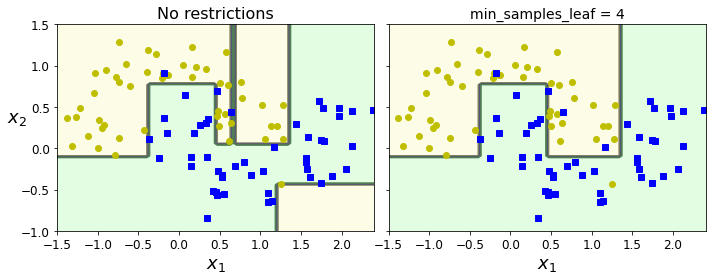

In [44]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
# mean_sample_leaf : 리프 노드가 될 최소 샘플의 개수. 
# 어떤 노드가 분할을 했는데 이 값보다 자식 노드의 샘플 개수가 적어지면 분할을 하지 않도록 함
# 정수를 주면 개수, 실수를 주면 비율
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

#### 데이터셋이 회전하면 결정 경계가 바뀌는 특성이 있음

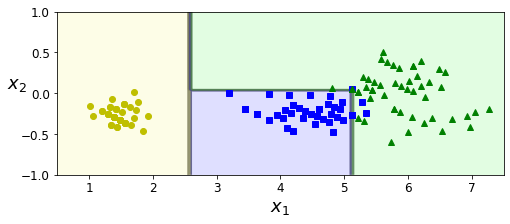

In [45]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

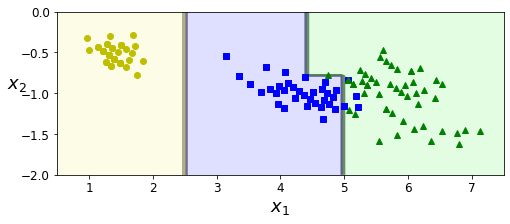

In [49]:
angle = np.pi / 180 * 30
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -2.0, 0], iris=False)

plt.show()

그림 저장: sensitivity_to_rotation_plot


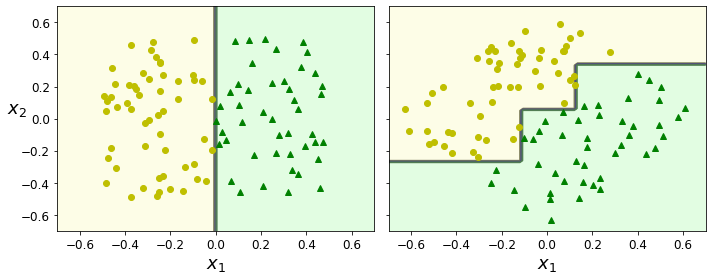

In [46]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

# 회귀

**$ y = 4(x-0.5)^{2}$**

In [50]:
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [51]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

그림 저장: tree_regression_plot


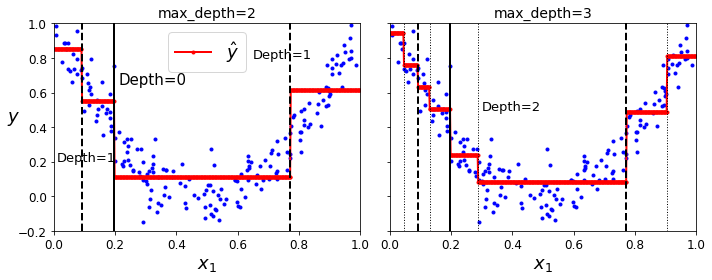

In [52]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

In [53]:
export_graphviz(
        tree_reg1,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

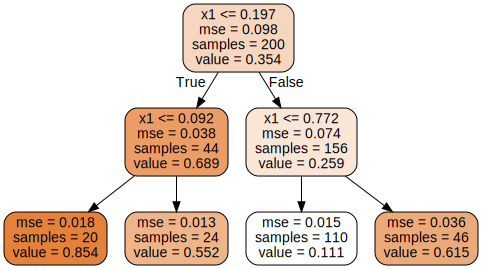

In [54]:
Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

## min_sample_leaf 규제를 한 모델과 하지 않은 모델의 비교

그림 저장: tree_regression_regularization_plot


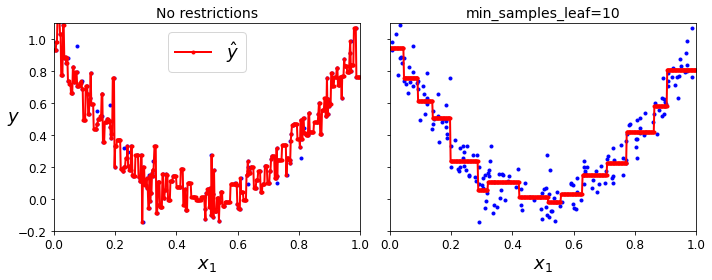

In [55]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

# 연습문제

## 7. moons 데이터셋에 결정 트리 훈련시키고 세밀하게 튜닝하기

In [92]:
from sklearn.tree import DecisionTreeClassifier

In [94]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 1000, noise = 0.4, random_state = 42)

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [96]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    1.3s finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [97]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=4, random_state=42)

In [98]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.855